# Magnimind Academy - ML Bootcamp - NLP Project

### Problem description:

Existing process:
1. A rule-based algorithm (<span style='color:red'>henceforth refered to as 'RBA'</span>) assigns each tweet to one of a set of categories (Business, Animal, Weather, etc.) based on the text of the tweet;
2. A human editor reads the text of the tweet and views any associated pictures or videos (if available) and determines whether the the RBA's categorization is correct.

The goal of this project is to develop an NLP classifier to perform the human editor's task. The NLP classifier will:
1. Predict the *edInput* column (label);
2. By analyzing some selected set of columns (features) in the tweet_data.csv file - the exact set of features will be determined by trial and error;
3. The false positive rate is to be minimized. For example, if a tweet is labeled as 'Sports,' we do not want the user to click on it only to find out that the tweet has nothing to do with sports;
4. Only the 'Business' category is to be considered.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

## Read the raw tweet data

In [2]:
tweet_file_name = 'tweet_data.csv'

In [3]:
df_tweets = pd.read_csv(tweet_file_name)

What is the size of the data?

In [4]:
print('The raw data set contains {} rows and {} columns'.format(df_tweets.shape[0], df_tweets.shape[1]))

The raw data set contains 785916 rows and 18 columns


## Data exploration and preparation

What are the columns?

In [5]:
df_tweets.columns

Index(['tweetID', 'crDate', 'edInput', 'editor', 'engages', 'isApproved',
       'isEdNeed', 'isRT', 'likes', 'photoUrl', 'retweets', 'rtUsID', 'text',
       'topicName', 'usFlwrs', 'usID', 'usName', 'videoUrl'],
      dtype='object')

What are the categories?

In [6]:
df_tweets['topicName'].unique()

array(['Business', 'Animal', 'Memes', 'Nature', 'Travel', 'Interesting',
       'News', 'Fashion', 'Art', 'Personal Development', 'Motivational',
       'DIY & Craft', 'Editorial Pics', 'Funny', 'Poem', 'World Leaders',
       'Entrepreneurship', 'US News', 'Journalists', 'Flowers',
       'Cryptocurrency', 'Photography', 'Design & Architecture',
       'Fitness', 'Spirituality', 'Startup', 'Space', 'Technology',
       'Digital Media & Internet', 'Psychology', 'Science', 'Basketball',
       'Humor', 'Mindfulness', 'Medical', 'Informative', 'Love', 'Stocks',
       'Nanotech', 'Biotech', 'science', 'Random'], dtype=object)

'Science' and 'science' are probably meant to be one category. Normally, I would change 'science' to 'Science' in the *topicName* column. Since this project is only concerned with the 'Business' category, the rows for all the other categories are going to be deleted, so I won't change 'science' to 'Science'.

### Keep only the 'Business' category rows

In [7]:
# drop all rows that are not for the Business category.
keep_category = 'Business'
df_tweets = df_tweets[df_tweets['topicName'] == keep_category]

What is the size of the remaining data?

In [8]:
df_tweets.shape

(164602, 18)

### Check the data type of each column.

In [9]:
df_tweets.dtypes

tweetID        int64
crDate        object
edInput        int64
editor         int64
engages        int64
isApproved      bool
isEdNeed        bool
isRT            bool
likes          int64
photoUrl      object
retweets       int64
rtUsID         int64
text          object
topicName     object
usFlwrs        int64
usID           int64
usName        object
videoUrl      object
dtype: object

The expected numeric columns show up as int64. The columns of type 'object' need a closer look since it can indicate that different data types are present.

### Check numeric data

In [10]:
df_tweets.describe(include='int64')

,tweetID,edInput,editor,engages,likes,retweets,rtUsID,usFlwrs,usID
count,1.646020e+05,164602.000000,164602.000000,164602.000000,164602.000000,164602.000000,1.646020e+05,1.646020e+05,1.646020e+05
mean,1.107667e+18,-0.222166,1254.711127,96.121779,64.771607,31.350172,5.284982e+13,3.813214e+06,7.074258e+15
std,2.471932e+16,1.475269,2169.952625,1520.023744,1211.638565,334.185119,6.780304e+15,3.400048e+06,7.992100e+16
min,9.403631e+17,-1.000000,-1.000000,1.000000,0.000000,0.000000,-1.000000e+00,3.000000e+00,1.022100e+04
25%,1.085593e+18,-1.000000,-1.000000,19.000000,12.000000,7.000000,-1.000000e+00,2.504196e+06,1.689648e+07
50%,1.106266e+18,-1.000000,-1.000000,36.000000,22.000000,13.000000,-1.000000e+00,2.712062e+06,2.814065e+07
75%,1.128041e+18,1.000000,5001.000000,70.000000,45.000000,26.000000,-1.000000e+00,5.243273e+06,3.471336e+07
max,1.154179e+18,4.000000,5008.000000,244498.000000,202056.000000,56654.000000,8.699186e+17,6.221739e+07,1.084561e+18


Observations about numeric variables:
1. The count equals the number of rows for all the numeric columns, so the are no missing entries;
2. The median for *edInput* is -1, meaning at least half of the rows have not yet been checked by a human editor. These rows cannot be used for training or testing, and will have to be removed;
3. Similarly, the median for *editor* is -1, meaning at least half the rows have not been assigned a human editor to check the RBA categization. These rows should have -1 in the *edInput* column;
4. Some rows have *edInput* greater than 2. These rows have either already been classified (and are duplicates), or the human editor is unsure about the correct classification.

### Only keep rows where the RBA categorization has been checked by a human editor

*edInput* is marked as follows:
* -1: not yet labeled;
* 1: classification is True (correct);
* 2: classification is False (incorrect);
* 3: human editors are not sure if the classification is correct;
* 4: the classification is True (correct) but this tweet is already displayed.

In [11]:
df_tweets = df_tweets[df_tweets['edInput'].isin([1, 2]) == True]

What is the size of the remaining data?

In [12]:
df_tweets.shape

(30024, 18)

### Check numeric data again

In [13]:
df_tweets.describe(include='int64')

,tweetID,edInput,editor,engages,likes,retweets,rtUsID,usFlwrs,usID
count,3.002400e+04,30024.000000,30024.000000,30024.000000,30024.000000,30024.000000,3.002400e+04,3.002400e+04,3.002400e+04
mean,1.126049e+18,1.405942,5004.619271,216.237443,151.575373,64.662070,5.333473e+06,3.603612e+06,9.435653e+15
std,1.608622e+16,0.491082,1.460386,3005.523592,2402.731659,632.124796,5.389986e+07,2.654004e+06,9.051669e+16
min,1.072759e+18,1.000000,5001.000000,1.000000,0.000000,0.000000,-1.000000e+00,1.870000e+02,7.673960e+05
25%,1.111217e+18,1.000000,5004.000000,49.000000,31.000000,17.000000,-1.000000e+00,2.574673e+06,2.056264e+07
50%,1.125888e+18,1.000000,5004.000000,73.000000,47.000000,26.000000,-1.000000e+00,2.723230e+06,3.471336e+07
75%,1.140068e+18,2.000000,5004.000000,133.000000,87.000000,47.000000,-1.000000e+00,5.317818e+06,3.471336e+07
max,1.154172e+18,2.000000,5008.000000,244498.000000,202056.000000,56654.000000,3.333216e+09,6.221739e+07,1.067219e+18


Observations about remaining numeric data:
1. *edInput* does not have values less than 1 and greater than 2 - that's good;
2. All remaining rows had an editor assigned to them (no rows have *editor* equal to -1) - also good;
3. What is *rtUsID*? Is it the user ID? At least 75% of the *rtUsID* are missing and something may have to be done about these entries.

### Check non-numeric data

In [14]:
df_tweets.describe(exclude='int64')

,crDate,isApproved,isEdNeed,isRT,photoUrl,text,topicName,usName,videoUrl
count,30024,30024,30024,30024,2389,30024,30024,30024,7184
unique,29838,2,1,2,2378,30021,1,449,3262
top,2019-05-02 18:20:00,True,True,False,https://pbs.twimg.com/media/C16cvwrUkAEvjtc.jpg,Google spent 10 years researching what makes t...,Business,Bloomberg,https://video.twimg.com/amplify_video/11008289...
freq,3,17836,30024,25346,4,2,30024,11467,14


Observation: The count for *photoUrl* and *videoUrl* is less than the number of rows - these columns have missing values. While photos and videos will not be used as features in the present exercise, just the presence of absence of an associated photo or video may be associated with the human editor's classification. We will replace the photo and video URL column with a 0 if there is no URL and a 1 if there is a URL.

### Modify photo column to indicate if a photo is available. Same for video column.

In [15]:
df_tweets[['photoUrl', 'videoUrl']] = np.where(df_tweets[['photoUrl', 'videoUrl']].isnull(), np.int64(0), np.int64(1))

In [16]:
df_tweets.describe(include='int64')

,tweetID,edInput,editor,engages,likes,photoUrl,retweets,rtUsID,usFlwrs,usID,videoUrl
count,3.002400e+04,30024.000000,30024.000000,30024.000000,30024.000000,30024.00000,30024.000000,3.002400e+04,3.002400e+04,3.002400e+04,30024.000000
mean,1.126049e+18,1.405942,5004.619271,216.237443,151.575373,0.07957,64.662070,5.333473e+06,3.603612e+06,9.435653e+15,0.239275
std,1.608622e+16,0.491082,1.460386,3005.523592,2402.731659,0.27063,632.124796,5.389986e+07,2.654004e+06,9.051669e+16,0.426648
min,1.072759e+18,1.000000,5001.000000,1.000000,0.000000,0.00000,0.000000,-1.000000e+00,1.870000e+02,7.673960e+05,0.000000
25%,1.111217e+18,1.000000,5004.000000,49.000000,31.000000,0.00000,17.000000,-1.000000e+00,2.574673e+06,2.056264e+07,0.000000
50%,1.125888e+18,1.000000,5004.000000,73.000000,47.000000,0.00000,26.000000,-1.000000e+00,2.723230e+06,3.471336e+07,0.000000
75%,1.140068e+18,2.000000,5004.000000,133.000000,87.000000,0.00000,47.000000,-1.000000e+00,5.317818e+06,3.471336e+07,0.000000
max,1.154172e+18,2.000000,5008.000000,244498.000000,202056.000000,1.00000,56654.000000,3.333216e+09,6.221739e+07,1.067219e+18,1.000000


Observations:
1. 8% of the rows have a photo;
2. 24% of the rows have a video.

### Check the remaining non-numeric columns

In [17]:
df_tweets.describe(exclude='int64')

,crDate,isApproved,isEdNeed,isRT,text,topicName,usName
count,30024,30024,30024,30024,30024,30024,30024
unique,29838,2,1,2,30021,1,449
top,2019-05-02 18:20:00,True,True,False,Google spent 10 years researching what makes t...,Business,Bloomberg
freq,3,17836,30024,25346,2,30024,11467


Observations about remaining non-numeric columns:
1. No missing entries in any of the columns;
2. The *topicName* column only has one entry ('Business'), as expected. This column can be dropped;
3. The *isEdNeed* column has only one entry ('True'). This will not add any information for the modeling, and can be dropped;
4. What does *isApproved* mean? It is boolean, and should be converted to 1/0 so it can be used in modeling.
5. What does *isRT* mean? It is boolean, and should be converted to 1/0 so it can be used in modeling.

### Drop the *topicName* and *isEdNeed* columns

In [18]:
df_tweets.drop(columns=['topicName', 'isEdNeed'], inplace=True)

### Convert *isRT* and *isApproved* from `bool` to `int`

In [19]:
df_tweets[['isApproved', 'isRT']] = np.where(df_tweets[['isApproved', 'isRT']] == True, np.int64(1), np.int64(0))

In [20]:
df_tweets.describe(include='int64')

,tweetID,edInput,editor,engages,isApproved,isRT,likes,photoUrl,retweets,rtUsID,usFlwrs,usID,videoUrl
count,3.002400e+04,30024.000000,30024.000000,30024.000000,30024.000000,30024.000000,30024.000000,30024.00000,30024.000000,3.002400e+04,3.002400e+04,3.002400e+04,30024.000000
mean,1.126049e+18,1.405942,5004.619271,216.237443,0.594058,0.155809,151.575373,0.07957,64.662070,5.333473e+06,3.603612e+06,9.435653e+15,0.239275
std,1.608622e+16,0.491082,1.460386,3005.523592,0.491082,0.362680,2402.731659,0.27063,632.124796,5.389986e+07,2.654004e+06,9.051669e+16,0.426648
min,1.072759e+18,1.000000,5001.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-1.000000e+00,1.870000e+02,7.673960e+05,0.000000
25%,1.111217e+18,1.000000,5004.000000,49.000000,0.000000,0.000000,31.000000,0.00000,17.000000,-1.000000e+00,2.574673e+06,2.056264e+07,0.000000
50%,1.125888e+18,1.000000,5004.000000,73.000000,1.000000,0.000000,47.000000,0.00000,26.000000,-1.000000e+00,2.723230e+06,3.471336e+07,0.000000
75%,1.140068e+18,2.000000,5004.000000,133.000000,1.000000,0.000000,87.000000,0.00000,47.000000,-1.000000e+00,5.317818e+06,3.471336e+07,0.000000
max,1.154172e+18,2.000000,5008.000000,244498.000000,1.000000,1.000000,202056.000000,1.00000,56654.000000,3.333216e+09,6.221739e+07,1.067219e+18,1.000000


In [21]:
df_tweets.describe(exclude='int64')

,crDate,text,usName
count,30024,30024,30024
unique,29838,30021,449
top,2019-05-02 18:20:00,Google spent 10 years researching what makes t...,Bloomberg
freq,3,2,11467


There are 30,024 rows, but only 30,021 unique entries in the text column. There must be three duplicates. They may have been missed being marked as *edInput* = 4.

In [22]:
duplicated_text = df_tweets[df_tweets.duplicated(subset='text')]['text']

In [23]:
df_tweets[df_tweets['text'] == duplicated_text.values[0]]

,tweetID,crDate,edInput,editor,engages,isApproved,isRT,likes,photoUrl,retweets,rtUsID,text,usFlwrs,usID,usName,videoUrl
492751,1127166284746063872,2019-05-11 10:59:18,1,5004,97,1,0,74,0,23,-1,Better management can change everything.\n#Web...,5415471,14800270,Harvard Biz Review,0
500909,1128080017681014784,2019-05-13 23:30:09,1,5004,59,1,0,43,0,16,-1,Better management can change everything.\n#Web...,5415503,14800270,Harvard Biz Review,0


In [24]:
df_tweets[df_tweets['text'] == duplicated_text.values[1]]

,tweetID,crDate,edInput,editor,engages,isApproved,isRT,likes,photoUrl,retweets,rtUsID,text,usFlwrs,usID,usName,videoUrl
641896,1142131119770546181,2019-06-21 18:04:13,1,5008,62,1,0,42,0,20,-1,8 predictions made by Amazon CEO Jeff Bezos 20...,2627639,20562637,Business Insider,0
733436,1150086008433717250,2019-07-13 16:54:06,1,5008,60,1,0,43,0,17,-1,8 predictions made by Amazon CEO Jeff Bezos 20...,2642488,20562637,Business Insider,0


In [25]:
df_tweets[df_tweets['text'] == duplicated_text.values[2]]

,tweetID,crDate,edInput,editor,engages,isApproved,isRT,likes,photoUrl,retweets,rtUsID,text,usFlwrs,usID,usName,videoUrl
651002,1143117897495130114,2019-06-24 11:25:19,1,5008,403,1,0,275,0,128,-1,Google spent 10 years researching what makes t...,2629490,20562637,Business Insider,0
764651,1152576431827881985,2019-07-20 13:50:09,1,5008,296,1,0,202,0,94,-1,Google spent 10 years researching what makes t...,2647332,20562637,Business Insider,0


Each of the above three tweets appears twice in the data set. The *text*, *usName*, *usID* are the same within each pair. This could be handled in different ways. For example:
1. One of the duplicate rows could be deleted;
2. The information (*likes*, *retweets*, etc.) could be combined in some manner.
Since there are only three out of 30,024 rows, I will leave it as it is.

In [26]:
df_tweets['crDate'].describe()

count                   30024
unique                  29838
top       2019-05-02 18:20:00
freq                        3
Name: crDate, dtype: object

### Assuming the exact timestamp is not critical, replace datetime by date

In [27]:
df_tweets['crDate'] = pd.to_datetime(df_tweets['crDate']).dt.date

In [28]:
df_tweets['crDate'].describe()

count          30024
unique           162
top       2019-04-22
freq             348
Name: crDate, dtype: object

### Redefine *edInput*

One last thing - the *edInput* column contains 1s to denote correct classification and 2s to denote incorrect classification. Convert this to 1 for correct classification and 0 for incorrect classification.

In [29]:
df_tweets['edInput'] = 2 - df_tweets['edInput']

### Check if there is a 1:1 correspondence between usID and usName

In [30]:
print('there are {} unique user names and {} unique user IDs'.format(df_tweets['usName'].nunique(), 
                                                                     df_tweets['usID'].nunique()))

there are 449 unique user names and 443 unique user IDs


There are more user names than user IDs. Find out which usID have multiple associated usName:

In [31]:
for id in df_tweets['usID'].unique():
    if df_tweets[df_tweets['usID'] == id]['usName'].nunique() != 1:
        print('usID {} has {} associated usName: {}'.format(id, df_tweets[df_tweets['usID'] == id]['usName'].nunique(), 
                                                            df_tweets[df_tweets['usID'] == id]['usName'].unique()))

usID 14800270 has 2 associated usName: ['Harvard Biz Review' 'Harvard Business Review']
usID 252751061 has 2 associated usName: ['TicToc by Bloomberg' 'Bloomberg TicToc']
usID 74292666 has 3 associated usName: ['Erin Brodwin 🤖' 'Erin Brodwin' 'Erin Brodwin ⚡️']
usID 2369949012 has 2 associated usName: ['Joe Perticone' 'Joe']
usID 26024026 has 2 associated usName: ['daniel mcmahon' 'DANIEL McMAHON']
usID 1684471004 has 2 associated usName: ['Ashley Rodriguez' 'Ashley Rodriguez 📺']


Clean this up by assigning a uniform *usName* for each of these *usID*.

In [32]:
df_tweets.loc[(df_tweets['usID'] == 14800270), 'usName'] = 'Harvard Business Review'

In [33]:
df_tweets.loc[(df_tweets['usID'] == 252751061), 'usName'] = 'Bloomberg TicToc'

In [34]:
df_tweets.loc[(df_tweets['usID'] == 74292666), 'usName'] = 'Erin Brodwin'

In [35]:
df_tweets.loc[(df_tweets['usID'] == 2369949012), 'usName'] = 'Joe Perticone'

In [36]:
df_tweets.loc[(df_tweets['usID'] == 26024026), 'usName'] = 'DANIEL McMAHON'

In [37]:
df_tweets.loc[(df_tweets['usID'] == 1684471004), 'usName'] = 'Ashley Rodriguez'

In [38]:
print('there are {} unique user names and {} unique user IDs'.format(df_tweets['usName'].nunique(), 
                                                                     df_tweets['usID'].nunique()))

there are 442 unique user names and 443 unique user IDs


Which *usName* have more than one *usID*?

In [39]:
for id in df_tweets['usName'].unique():
    if df_tweets[df_tweets['usName'] == id]['usID'].nunique() != 1:
        print('usName {} has {} associated usID: {}'.format(id, df_tweets[df_tweets['usName'] == id]['usID'].nunique(), 
                                                            df_tweets[df_tweets['usName'] == id]['usID'].unique()))

usName World Economic Forum has 2 associated usID: [  5120691 102700680]


In [40]:
df_tweets[df_tweets['usID'] == 5120691].shape

(18, 16)

In [41]:
df_tweets[df_tweets['usID'] == 102700680].shape

(1, 16)

I hesitate to change the *usID*. Since there is only one tweet using the second *usID*, it should not make s huge difference.

### Examine timestamps

In [42]:
print('timestamps range from {} to {}'.format(df_tweets['crDate'].min(), df_tweets['crDate'].max()))

timestamps range from 2018-12-12 to 2019-07-24


Plot number of daily tweets

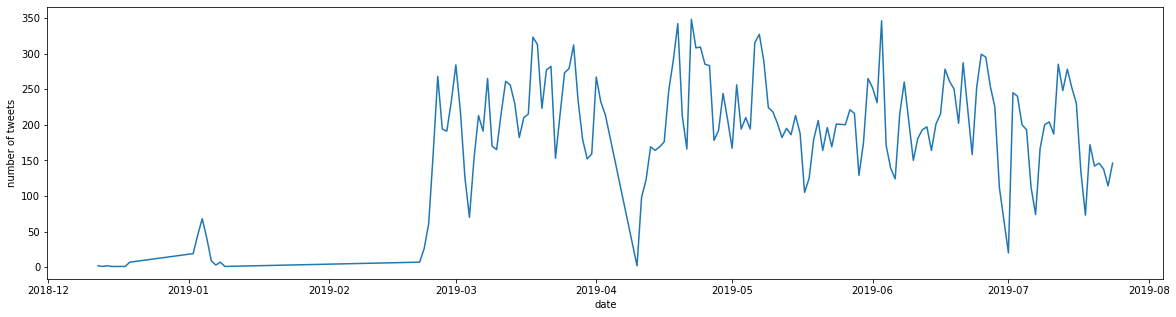

In [43]:
plt.figure(figsize=(20,5))
plt.plot(df_tweets.groupby('crDate')['tweetID'].count())
plt.xlabel('date')
plt.ylabel('number of tweets');

Observations:
1. There are very few tweets in the data set before March 2019. Perhaps the 'Business' category was added on a trial basis at the beginning of January 2019 and on a permanent basis at the end of February 2019;
2. There appears to be some issue with the numbers of daily tweets in the database mid-2019.

In the time period with low daily tweet count, there may have been a problem with data collection/retention.

### Check for imbalance

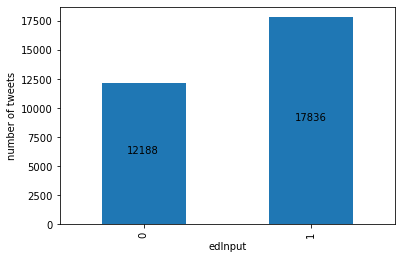

In [44]:
df_tweets.groupby('edInput')['edInput'].count().plot.bar()
plt.ylabel('number of tweets')
for index, value in enumerate(df_tweets.groupby('edInput')['edInput'].count()):
    plt.text(index-0.1, value / 2, str(value))

The data set is reasonably balanced: 12188 incorrect categorizations versus 17836 correct categorizations. Not so good performance by the rule-based algorithm, but a good data set for our purposes!

### Check for patterns of correct/incorrect categorization in different columns

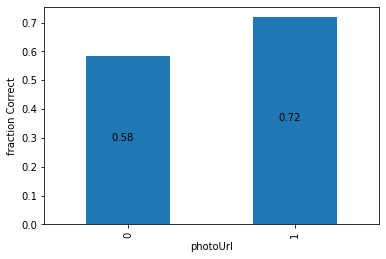

In [45]:
df_tweets.groupby('photoUrl')['edInput'].mean().plot.bar()
plt.ylabel('fraction Correct')
for index, value in enumerate(df_tweets.groupby('photoUrl')['edInput'].mean()):
    plt.text(index-0.1, value / 2, str(round(value, 2)))

1. When there is a photo, 72% of the categorizations are correct;
2. When there is no photo, 58% of the categorizations are correct.

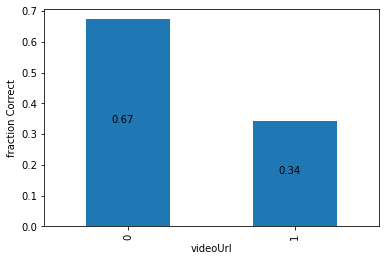

In [46]:
df_tweets.groupby('videoUrl')['edInput'].mean().plot.bar()
plt.ylabel('fraction Correct')
for index, value in enumerate(df_tweets.groupby('videoUrl')['edInput'].mean()):
    plt.text(index-0.1, value / 2, str(round(value, 2)))

1. When there is a video, 34% of the categorizations are correct;
2. When there is no video, 67% of the categorizations are correct.

Text(0.5, 1.0, 'daily categorization success rate for business tweets')

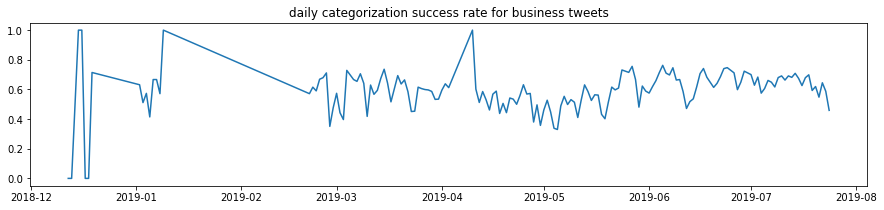

In [47]:
plt.figure(figsize=(15,3))
plt.plot(df_tweets.groupby('crDate')['edInput'].mean())
plt.title('daily categorization success rate for business tweets')

Text(0.5, 1.0, 'daily tweets')

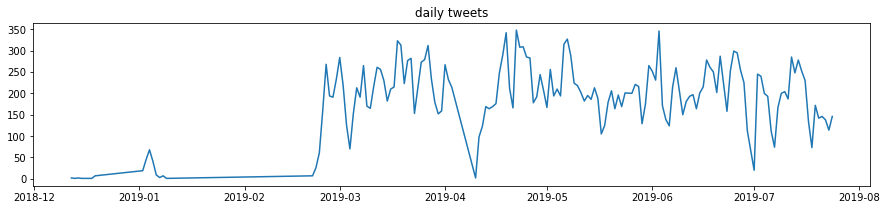

In [48]:
plt.figure(figsize=(15,3))
plt.plot(df_tweets.groupby('crDate')['edInput'].count())
plt.title('daily tweets')

Once the Business category was introduced, the correct categorization rate fluctuated between 40% and 70% (just from a visual inspection of the above two charts).

Which tweeters had the most tweets in 'Business' as categorized the RBA?

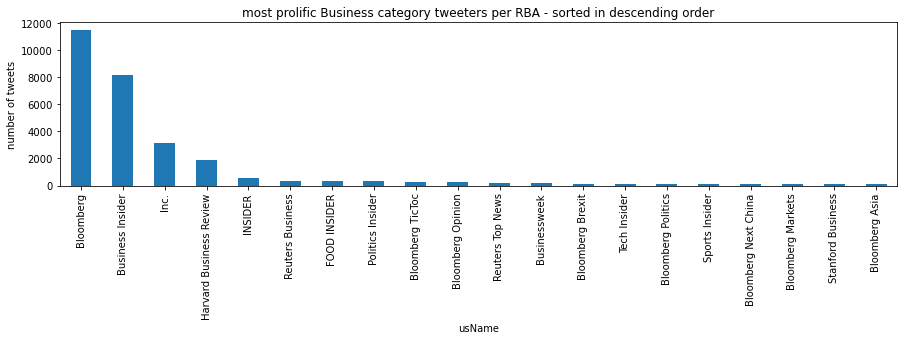

In [49]:
plt.figure(figsize=(15,3))
df_tweets.groupby('usName')['edInput'].count().sort_values(ascending=False)[:20].plot.bar()
plt.title('most prolific Business category tweeters per RBA - sorted in descending order')
plt.ylabel('number of tweets');

Text(0, 0.5, 'cumulative tweets')

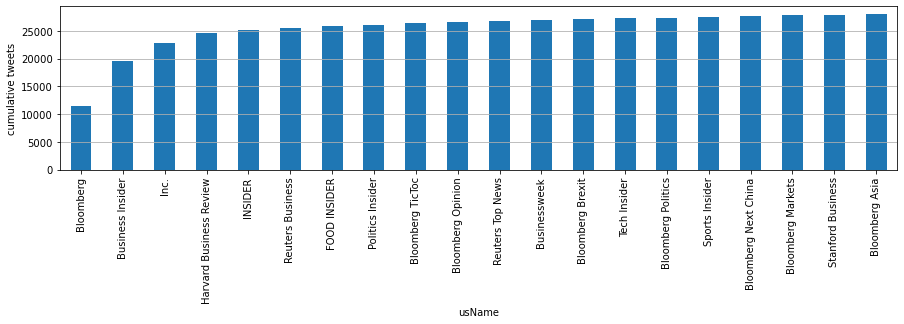

In [50]:
plt.figure(figsize=(15,3))
df_tweets.groupby('usName')['edInput'].count().sort_values(ascending=False).cumsum()[:20].plot.bar()
plt.grid(b=True, axis='y')
plt.ylabel('cumulative tweets')

About 25000 of the 30000 tweets flagged as 'Business' were by the top five or six users.

### Does the success rate for a user depend upon how much a user tweets?

Fifteen most-prolific tweeters:

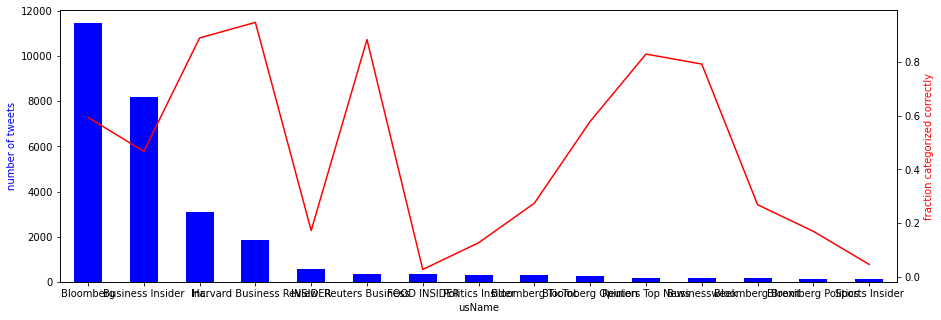

In [51]:
plt.figure(figsize=(15,5))
ax1 = df_tweets.groupby('usName')['edInput'].agg(['count', 'mean']).sort_values('count', 
    ascending=False)[:15]['count'].plot.bar(color='blue')
ax2 = df_tweets.groupby('usName')['edInput'].agg(['count', 'mean']).sort_values('count', 
    ascending=False)[:15]['mean'].plot(secondary_y=True, color='red')
ax1.set_ylabel('number of tweets', color='blue')
ax2.set_ylabel('fraction categorized correctly', color='red');

All tweeters:

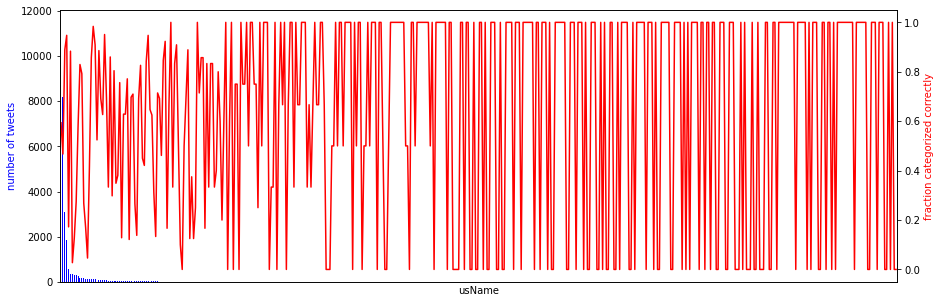

In [52]:
import matplotlib.ticker as ticker

plt.figure(figsize=(15,5))

ax1 = df_tweets.groupby('usName')['edInput'].agg(['count', 'mean']).sort_values('count', 
    ascending=False)['count'].plot.bar(color='blue')
ax2 = df_tweets.groupby('usName')['edInput'].agg(['count', 'mean']).sort_values('count', 
    ascending=False)['mean'].plot(secondary_y=True, color='red')

# the next two lines of code prevent xtick labels. there are hundreds of xtick labels.
# this requires a very small font, which produces multiple warnings.
ax1.xaxis.set_major_locator(ticker.NullLocator()) 
ax2.xaxis.set_major_locator(ticker.NullLocator())

ax1.set_ylabel('number of tweets', color='blue')
ax2.set_ylabel('fraction categorized correctly', color='red');

Here are the top-25 tweeters sorted by categorization success rate.

In [53]:
df_tweets.groupby('usName')['edInput'].agg(['count', 'mean']).sort_values('count', ascending=False)[:25].sort_values('mean', ascending=False)['mean']

usName
Bloomberg Markets          0.983740
Joe Weisenthal             0.950820
Harvard Business Review    0.947509
Stanford Business          0.909091
Inc.                       0.889318
Bloomberg Economics        0.885714
Reuters Business           0.883382
Bloomberg Next China       0.857143
Reuters Top News           0.829412
Businessweek               0.792208
Bloomberg Crypto           0.694915
ReutersBreakingviews       0.691176
Bloomberg TV               0.626866
Bloomberg                  0.593616
Bloomberg Opinion          0.578740
Bloomberg Asia             0.524272
Business Insider           0.467115
Tech Insider               0.415385
Bloomberg TicToc           0.274021
Bloomberg Brexit           0.268456
INSIDER                    0.172352
Bloomberg Politics         0.169231
Politics Insider           0.126667
Sports Insider             0.046154
FOOD INSIDER               0.027356
Name: mean, dtype: float64

Observations:
1. Tweeters who had only one tweet (right-hand-side of lower chart), the success rate was either 0% or 100% - not surprising;
2. Is there a pattern among prolific tweeters? It might be more statistically significant than the low-volume tweeters. Among the most-prolific tweeters (left-hand side of lower chart, or upper chart, or table), success rate appears to be higher for tweeters that are business-oriented as indicated by the *usName*, e.g., 'Business Insider', 'Harvard Business Review', 'Reuters Business', 'Businessweek', etc. These have some business-related word in the user name. But there are also exceptions like 'Joe Weisenthal. **What I am trying to get at is that some users may write a tweet in a way that makes it obvious that it is business-related. How to flag/identify such users? I am reluctant to one-hot-encode the *usName* at this time - there are too many. I'll leave it here for now.**

Is there any relationship between *isApproved* and *edInput*?

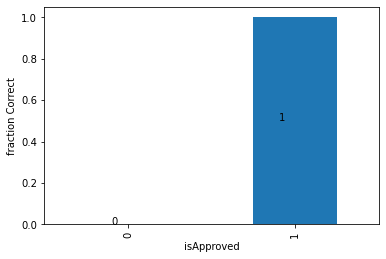

In [54]:
df_tweets.groupby('isApproved')['edInput'].mean().plot.bar()
plt.ylabel('fraction Correct')
for index, value in enumerate(df_tweets.groupby('isApproved')['edInput'].mean()):
    plt.text(index-0.1, value / 2, str(round(value, 2)))

There is a 1:1 relationship. *isApproved* is probably a function of *edInput*. I will not use it as a feature.

How well does *edInput* correlate with the other numeric inputs?

In [55]:
df_tweets.corr().loc['edInput']

tweetID       0.055934
edInput       1.000000
editor        0.071926
engages      -0.014906
isApproved    1.000000
isRT         -0.131470
likes        -0.013739
photoUrl      0.074383
retweets     -0.018651
rtUsID       -0.015425
usFlwrs       0.098003
usID         -0.025960
videoUrl     -0.286741
Name: edInput, dtype: float64

... not too well. The strongest correlation is with the absence of a video. These numeric inputs are probably not good features. Some of them - *editor*, *engages*, *rtUsID*, *usID* - are 'numeric' in name only. The text of the tweet, hopefully, is the strongest indicator of category.

### Of the columns examined so far, I will include the presence/absence of a photo and video as features. The *usName* or *usID* may be a good feature, but I am reluctant to add almost 500 new columns at this point.

### Save the dataframe to a pickle file so that  the above steps do not have to be repeated.

In [56]:
pd.to_pickle(df_tweets, 'df_tweets.pkl')

## Model

In [57]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ashut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashut\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Examine a few tweets:

In [58]:
df_tweets['text']

12252     UK Prime Minister Theresa May will face a vote...
14042     UK PM Theresa May wins confidence vote with 20...
16954     The probe of the inaugural fund partly arises ...
18004     The week Brexit hit the brick wall :  Commons ...
18396     Have watched these kinds of pictures looking f...
                                ...                        
785779    This bouquet of roses is completely edible htt...
785809    This fancy McDonald's has a handwashing statio...
785813    🚨 Spoilers ahead 🚨\nFinished #StrangerThings? ...
785829    These cakes are topped with yogurt 🎂 https://t...
785854    Are you team Shake Shack or team In-N-Out? htt...
Name: text, Length: 30024, dtype: object

The tweets contain emojis and URLs. As part of data cleaning, we will:
1. Replace the URLs with a string, 'urlplaceholder' just to note that the tweet contained a URL;
2. Remove the emojis.

### Create a tokenizer to normalize, tokenize, stem, lemmatize

In [59]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
urlplaceholder = 'urlplaceholder'

def tokenize_text(text):
    # replace URLs with placeholder
    text = re.sub(url_regex, urlplaceholder, text)
    
    # remove punctuation
    text = re.sub(r'[^a-zA-Z0-]',' ', text)
    
    # change to lower case
    text = text.lower()
    
    # remove stop words
    text = [word for word in text.split() if word not in stopwords.words('english')]
    
    # stem
    text = [PorterStemmer().stem(word) for word in text]
    
    # lemmatize
    text = [WordNetLemmatizer().lemmatize(word) for word in text]
    
    return text

## Fit a preliminary model.

In [60]:
X = df_tweets['text'].values
y = df_tweets['edInput'].values

In [61]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)

In [63]:
X_train.shape

(22518,)

In [64]:
X_test.shape

(7506,)

In [65]:
import time

In [66]:
start = time.perf_counter()
cv = CountVectorizer(tokenizer=tokenize_text)
X_train_count = cv.fit_transform(X_train)
print('{} seconds'.format(time.perf_counter() - start))

88.5641258 seconds


In [67]:
start = time.perf_counter()
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_count)
print('{} seconds'.format(time.perf_counter() - start))

0.011628500000000486 seconds


In [68]:
start = time.perf_counter()
X_test_count = cv.transform(X_test)
print('{} seconds'.format(time.perf_counter() - start))

28.91172990000001 seconds


In [69]:
start = time.perf_counter()
X_test_tfidf = tfidf.transform(X_test_count)
print('{} seconds'.format(time.perf_counter() - start))

0.0019258000000093034 seconds


In [70]:
start = time.perf_counter()
clf = BernoulliNB()
clf.fit(X_train_tfidf, y_train)
print('{} seconds'.format(time.perf_counter() - start))

0.005843999999996186 seconds


In [71]:
start = time.perf_counter()
y_test_pred = clf.predict(X_test_tfidf)
print('{} seconds'.format(time.perf_counter() - start))

0.0018838000000016564 seconds


In [72]:
def display_results(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)
    specificity = recall_score(y_test, y_pred, pos_label=0)
    precision = precision_score(y_test, y_pred, pos_label=1)

    print("confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("accuracy:", accuracy)
    print("recall:", recall)
    print("specificity:", specificity)
    print("precision:", precision)

In [73]:
# display results
display_results(y_test, y_test_pred)

confusion matrix:
 [[2160  876]
 [ 528 3942]]
accuracy: 0.8129496402877698
recall: 0.8818791946308725
specificity: 0.7114624505928854
precision: 0.8181818181818182


We want to maximize the recall (minimize false positives). Keep in mind that:
* Class 1 is Correct classification;
* Class 0 is Incorrect classification.

Without any attempt at optimization, a naive Bayes classifier produced recall = 0.88. This is promising. Next, I will try to improve the classifier performance by:
1. Dimensionality reduction;
2. Classifier selection;
3. Hyperparameter tuning.

## Dimensionality reduction

What is the number of features?

In [74]:
X_train_tfidf.shape

(22518, 16469)

The number of features is very large. I will try two methods of dimensionality reduction:
1. Truncated SVD (like PCA, but with sparse input);
2. Set a minimum document frequency when running `CountVectorizer`.

### TruncatedSVD

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [76]:
ss = StandardScaler(copy=True, with_mean=False)

In [77]:
X_train_scaled = ss.fit_transform(X_train_tfidf)

In [78]:
X_train_scaled.shape

(22518, 16469)

In [79]:
start = time.perf_counter()
tsvd = TruncatedSVD(n_components=5000, random_state=25)
tsvd.fit(X_train_scaled)
print('{} seconds'.format(time.perf_counter() - start))

210.58866030000002 seconds


In [80]:
sum(tsvd.explained_variance_ratio_)

0.6740396208223238

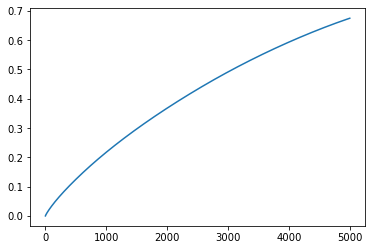

In [81]:
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))

5,000 compressed features retain less than 70% of the feature variance. This is not encouraging. From the shape of the curve, it appears that approximately 10,000 compressed features will be needed to capture 90% of feature variance.

How well does a naive Bayes classifier perform with 5,000 compressed features?

In [82]:
start = time.perf_counter()
clf = BernoulliNB()
clf.fit(tsvd.transform(X_train_scaled), y_train)
print('{} seconds'.format(time.perf_counter() - start))

2.6703791999999567 seconds


In [83]:
start = time.perf_counter()
X_test_scaled = ss.transform(X_test_tfidf)
y_test_pred = clf.predict(tsvd.transform(X_test_scaled))
print('{} seconds'.format(time.perf_counter() - start))

0.9796727000000374 seconds


In [84]:
# display results
display_results(y_test, y_test_pred)

confusion matrix:
 [[2246  790]
 [1128 3342]]
accuracy: 0.7444710897948308
recall: 0.7476510067114094
specificity: 0.7397891963109354
precision: 0.808809293320426


Classifier performance degraded. Using a larger number of will take a long time to fit `TruncatedSVD`.

### Try `CountVectorizer` with a minimum document frequency threshold.

Try `min_df`=5 (arbitrary choice).

In [85]:
start = time.perf_counter()
cv = CountVectorizer(tokenizer=tokenize_text, min_df=5)
X_train_count = cv.fit_transform(X_train)
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_count)
print('{} seconds'.format(time.perf_counter() - start))

86.93587390000005 seconds


In [86]:
start = time.perf_counter()
clf = BernoulliNB()
clf.fit(X_train_tfidf, y_train)
print('{} seconds'.format(time.perf_counter() - start))

0.005359200000043529 seconds


In [87]:
start = time.perf_counter()
X_test_count = cv.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_count)
print('{} seconds'.format(time.perf_counter() - start))

28.76968450000004 seconds


In [88]:
start = time.perf_counter()
y_test_pred = clf.predict(X_test_tfidf)
print('{} seconds'.format(time.perf_counter() - start))

0.0014386000000286003 seconds


In [89]:
# display results
display_results(y_test, y_test_pred)

confusion matrix:
 [[2207  829]
 [ 601 3869]]
accuracy: 0.8094857447375433
recall: 0.8655480984340045
specificity: 0.7269433465085638
precision: 0.823541932737335


Compared to the `CountVectorizer` with `min_df`=1, the accuracy and precision remained unchanged while the recall score dropped imperceptibly from 0.88 to 0.87.

## Try other classifiers

In [90]:
from sklearn.naive_bayes import BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

In [91]:
def fit_classifier(clf):
    
    start = time.perf_counter()
    
    clf.fit(X_train_tfidf, y_train)
    y_test_pred = clf.predict(X_test_tfidf)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    recall = recall_score(y_test, y_test_pred, pos_label=1)
    specificity = recall_score(y_test, y_test_pred, pos_label=0) # recall for class 0 is specificity of class 1
    precision = precision_score(y_test, y_test_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_test_pred)
    run_time = time.perf_counter() - start
    
    return tp, fp, tn, fn, recall, specificity, precision, accuracy, run_time

In [107]:
df_fit = pd.DataFrame(columns=['classifier', 'recall', 'specificity', 'precision', 'accuracy', 'tp', 'fp', 'tn', 'fn', 'runtime (sec)'])

In [108]:
cv = CountVectorizer(tokenizer=tokenize_text)
X_train_count = cv.fit_transform(X_train)
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_count)
X_test_count = cv.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_count)

In [109]:
classifiers = {'BernoulliNB': BernoulliNB(), 
               'RandomForest': RandomForestClassifier(random_state=25, n_jobs=-1), 
               'DecisionTree': DecisionTreeClassifier(random_state=25), 
               'GradientBoosting': GradientBoostingClassifier(random_state=25),
               'Ridge': RidgeClassifier(random_state=25),
               'Logistic': LogisticRegression(random_state=25),
               'SGD': SGDClassifier(random_state=25, n_jobs=-1),
               'KNeighbors': KNeighborsClassifier(n_jobs=-1),
               'ComplementNB': ComplementNB(),
               'SVC': SVC(random_state=25),
               'LinearSVC': LinearSVC(random_state=25)
              }

In [110]:
from tqdm import tqdm

In [111]:
for clf in tqdm(classifiers):
    tp, fp, tn, fn, recall, specificity, precision, accuracy, run_time = fit_classifier(classifiers[clf])
    df_fit = df_fit.append({'classifier': clf, 'recall': recall, 'specificity': specificity,
                            'precision': precision, 'accuracy': accuracy,
                            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn, 'runtime (sec)': run_time}, ignore_index=True)

100%|██████████| 11/11 [01:59<00:00, 10.87s/it]


In [112]:
df_fit.sort_values(by=['specificity'], ascending=False, inplace=True)

In [113]:
df_fit

,classifier,recall,specificity,precision,accuracy,tp,fp,tn,fn,runtime (sec)
10,LinearSVC,0.851454,0.749671,0.833552,0.810285,3806,760,2276,664,0.069180
9,SVC,0.881432,0.747036,0.836873,0.827072,3940,768,2268,530,102.205528
4,Ridge,0.865548,0.739460,0.830258,0.814548,3869,791,2245,601,0.043854
8,ComplementNB,0.880089,0.730567,0.827862,0.819611,3934,818,2218,536,0.016113
5,Logistic,0.880313,0.727602,0.826333,0.818545,3935,827,2209,535,0.198581
6,SGD,0.883221,0.719697,0.822671,0.817080,3948,851,2185,522,0.043913
1,RandomForest,0.870246,0.719368,0.820329,0.809219,3890,852,2184,580,2.650674
0,BernoulliNB,0.881879,0.711462,0.818182,0.812950,3942,876,2160,528,0.018984
7,KNeighbors,0.844072,0.691041,0.800892,0.782174,3773,938,2098,697,3.431412
2,DecisionTree,0.813647,0.666996,0.782487,0.754330,3637,1011,2025,833,5.273226


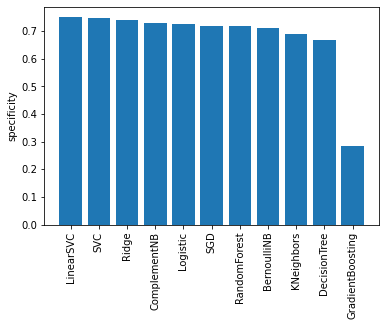

In [114]:
plt.bar(df_fit['classifier'], df_fit['specificity'])
plt.ylabel('specificity')
plt.xticks(rotation='vertical');

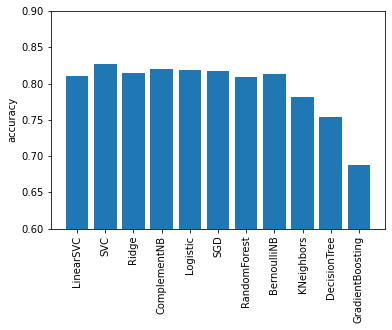

In [115]:
plt.bar(df_fit['classifier'], df_fit['accuracy'])
plt.ylabel('accuracy')
plt.xticks(rotation='vertical')
plt.ylim([0.6, 0.9]);

In [116]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [117]:
# test pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)

pipeline = Pipeline([
    ('cv', CountVectorizer(tokenizer=tokenize_text)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(random_state=25))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

display_results(y_test, y_pred)


confusion matrix:
 [[2276  760]
 [ 664 3806]]
accuracy: 0.810285105249134
recall: 0.8514541387024609
specificity: 0.7496706192358367
precision: 0.8335523434077967


In [118]:
# hyperparameter tuning pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25)

pipeline = Pipeline([
    ('cv', CountVectorizer(tokenizer=tokenize_text)),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(random_state=25))
])

parameters = {
    'clf__C': [0.5, 1, 2],
    'clf__class_weight': ['balanced', None]
}

gscv = GridSearchCV(pipeline, param_grid=parameters, verbose=3)

gscv.fit(X_train, y_train)
y_pred = gscv.predict(X_test)

display_results(y_test, y_pred)




Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] clf__C=0.5, clf__class_weight=balanced ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__C=0.5, clf__class_weight=balanced, score=0.813, total= 1.4min
[CV] clf__C=0.5, clf__class_weight=balanced ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV]  clf__C=0.5, clf__class_weight=balanced, score=0.805, total= 1.4min
[CV] clf__C=0.5, clf__class_weight=balanced ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s


[CV]  clf__C=0.5, clf__class_weight=balanced, score=0.808, total= 1.4min
[CV] clf__C=0.5, clf__class_weight=balanced ..........................
[CV]  clf__C=0.5, clf__class_weight=balanced, score=0.807, total= 1.4min
[CV] clf__C=0.5, clf__class_weight=balanced ..........................
[CV]  clf__C=0.5, clf__class_weight=balanced, score=0.801, total= 1.4min
[CV] clf__C=0.5, clf__class_weight=None ..............................
[CV] .. clf__C=0.5, clf__class_weight=None, score=0.814, total= 1.4min
[CV] clf__C=0.5, clf__class_weight=None ..............................
[CV] .. clf__C=0.5, clf__class_weight=None, score=0.813, total= 1.4min
[CV] clf__C=0.5, clf__class_weight=None ..............................
[CV] .. clf__C=0.5, clf__class_weight=None, score=0.810, total= 1.4min
[CV] clf__C=0.5, clf__class_weight=None ..............................
[CV] .. clf__C=0.5, clf__class_weight=None, score=0.808, total= 1.5min
[CV] clf__C=0.5, clf__class_weight=None ..............................


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 43.4min finished


confusion matrix:
 [[2273  763]
 [ 633 3837]]
accuracy: 0.8140154543032241
recall: 0.8583892617449664
specificity: 0.7486824769433466
precision: 0.8341304347826087


In [119]:
gscv.best_params_

{'clf__C': 0.5, 'clf__class_weight': None}